In [13]:
from pandas import Series, DataFrame
import pandas as pd
import calendar
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Setup

In [2]:
#read data in, appended 2014/2015, removed GO from col names
crime2014 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/Austin_Crime_2014.csv", dtype=unicode, encoding='utf-8')
crime2014[:3]

crime2015 = pd.read_csv("https://raw.githubusercontent.com/sxzhu/mis381_project/master/Austin_Crime_2015.csv", dtype=unicode, encoding='utf-8')
crime = crime2014.append(crime2015,ignore_index=True)

crime = crime.rename(index=str, columns={"Highest NIBRS/UCR Offense Description": "General Offense Description",\
                                 "GO Highest Offense Desc":"Detailed Offense Description",\
                                 "GO Location":"Location","GO Report Date":"Report Date",\
                                 "GO Location Zip":"Zipcode","GO District":"District","GO Census Tract":"Census Tract",\
                                 "GO X Coordinate":"X Coordinate","GO Y Coordinate":"Y Coordinate",\
                                      "GO Primary Key":"Primary Key"})

crime = crime.drop('Location_1', axis=1)
crime['Date'] = pd.DatetimeIndex(crime['Report Date'])
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Month'] = crime['Month'].apply(lambda x: calendar.month_abbr[x])
crime['Year'] = pd.DatetimeIndex(crime['Report Date']).year

## Merge Crimes

In [3]:
def merge_crimes(s):
    """Map some crimes together."""
    
    # Create a map of misspellings to correct spelling
    misspellings = {'Burglary / \nBreaking & Entering':'Burglary',
                    'Auto Theft':'Theft: Auto Parts',
                    'Homicide: Murder & Nonnegligent Manslaughter':'Murder',
                    'Agg Assault':'Aggravated Assault'}
    
    if s in misspellings:
        return misspellings[s]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_crimes)

def merge_theft(s):
    """Map some crimes together."""
    
    if (s[:5]=='Theft'):
        return s[:5]
    else:
        return s
    
# Apply the function to the Series
crime['General Offense Description'] = crime['General Offense Description'].map(merge_theft)

# Check that it worked
# mask = (crime['General Offense Description'] == 'Agg Assault')
# crime['General Offense Description'][mask]  # should be empty

crime['General Offense Description'].value_counts()

Theft                 61908
Burglary              10597
Aggravated Assault     3803
Robbery                1809
Rape                   1042
Murder                   55
Name: General Offense Description, dtype: int64

In [5]:
#Add the 'Streetname' column to both dataframes, keeping only the street name information
# removes leading numbers, leading hyphenated or / numbers, trailing 'NB', 'SB', 'EB', 'WB', trailing 'SVRD', and leading 'N', 'S', 'E', 'W'

crime['Streetname'] = crime['Location'].str.rsplit('\n', -1).str[0].str.replace('^[/\s\d-]+/?\d*\s+', '').str.replace('^BLOCK\s+', '').str.replace('\s[NSEW]B\s*$', '').str.replace('\sSVRD\s*$', '').str.replace('^\s*[NSEW]\s+', '').str.rstrip()
crime['PrimaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[0]
crime['SecondaryStreet'] = crime['Streetname'].str.rsplit(' / ', -1).str[1]

# Final Dataframe

In [6]:
crime.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Location,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet,SecondaryStreet
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,12151 N IH 35 SVRD NB ...,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35,NaN
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,3300 BLOCK ROCKHURST LN ...,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN,NaN
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,E 7TH ST / CHICON ST ...,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST,CHICON ST
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,WHELESS LN / BERKMAN DR ...,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN,BERKMAN DR
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,WALLER ST / E 2ND ST ...,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST,E 2ND ST


In [10]:
#make copy of dataframe
sliced = crime.loc[:, 'Clearance Date':'Detailed Offense Description'].merge(crime.loc[:, 'Zipcode':'PrimaryStreet'], right_index=True, left_index=True)
sliced.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST


In [42]:
#How many of each clearance type?
sliced = sliced[sliced['X Coordinate']>0]
sliced['Clearance Status'].value_counts()

N    61897
C    11003
O     1759
Name: Clearance Status, dtype: int64

In [44]:
sliced['Indicator'] = 0.0
sliced.loc[sliced['Clearance Status']=='C', 'Indicator'] = 1.0
sliced.loc[sliced['Clearance Status']=='N', 'Indicator'] = 2.0
sliced.head()

,Clearance Date,Clearance Status,Council District,Census Tract,District,Detailed Offense Description,Zipcode,Primary Key,Report Date,X Coordinate,Y Coordinate,General Offense Description,Date,Month,Year,Streetname,PrimaryStreet,Indicator
0,04/28/2014 12:00:00 AM,N,1,18.350000000000001,E,AGG ROBBERY/DEADLY WEAPON,78753,20141061920,04/17/2014 12:00:00 AM,3135985,10117220,Robbery,2014-04-17,Apr,2014,IH 35,IH 35,2.0
1,05/20/2014 12:00:00 AM,N,1,21.13,I,ROBBERY BY ASSAULT,78723,20141150937,04/25/2014 12:00:00 AM,3137985,10087946,Robbery,2014-04-25,Apr,2014,ROCKHURST LN,ROCKHURST LN,2.0
2,05/13/2014 12:00:00 AM,N,3,9.02,C,ROBBERY BY THREAT,78702,20141310316,05/11/2014 12:00:00 AM,3120890,10068910,Robbery,2014-05-11,May,2014,7TH ST / CHICON ST,7TH ST,2.0
3,03/24/2015 12:00:00 AM,C,1,21.04,I,AGG ROBBERY/DEADLY WEAPON,78723,20141670098,06/16/2014 12:00:00 AM,3130566,10089446,Robbery,2014-06-16,Jun,2014,WHELESS LN / BERKMAN DR,WHELESS LN,1.0
4,10/02/2014 12:00:00 AM,N,3,9.02,G,AGG ROBBERY/DEADLY WEAPON,78702,20142070292,07/26/2014 12:00:00 AM,3117732,10068195,Robbery,2014-07-26,Jul,2014,WALLER ST / E 2ND ST,WALLER ST,2.0


In [45]:
Y = pd.DataFrame(sliced['Indicator'])
X = pd.DataFrame(sliced[['X Coordinate', 'Y Coordinate']])
print 'Design matrix X'
print X[:5]
print 'Outcomes Y'
print Y[:5]

Design matrix X
  X Coordinate Y Coordinate
0      3135985     10117220
1      3137985     10087946
2      3120890     10068910
3      3130566     10089446
4      3117732     10068195
Outcomes Y
   Indicator
0        2.0
1        2.0
2        2.0
3        1.0
4        2.0


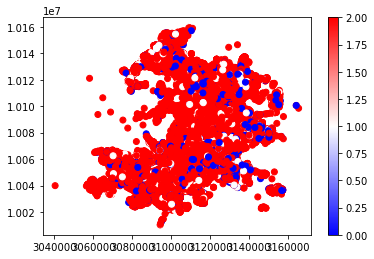

In [46]:
y = Y['Indicator'].values
sc = scatter(sliced['X Coordinate'], sliced['Y Coordinate'], c=y, cmap='bwr')
colorbar(sc)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [48]:
from sklearn import neighbors
model = neighbors.KNeighborsClassifier(n_neighbors=15,
                                       weights='uniform',
                                       p=2)

In [49]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [50]:
from sklearn import metrics
prediction_on_training = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_on_training)

0.818671750408


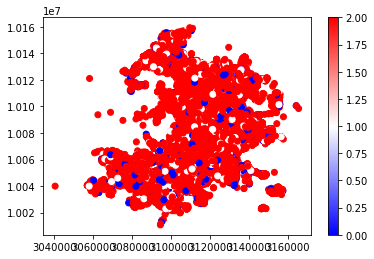

In [51]:
sc = scatter(X_train['X Coordinate'], X_train['Y Coordinate'], c=y_train, cmap='bwr')
colorbar(sc)

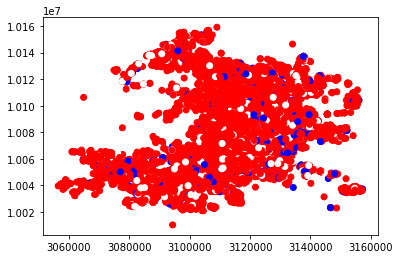

In [52]:
scatter(X_test['X Coordinate'], X_test['Y Coordinate'], c=y_test, cmap='bwr')

In [53]:
predicted_classes = model.predict(X_test)
print metrics.accuracy_score(y_test, predicted_classes)

0.819383259912


In [54]:
#Cross validation
from sklearn import model_selection

def cv_accuracy_score(X, y, nn):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    model = neighbors.KNeighborsClassifier(n_neighbors=nn,
                                           weights='uniform')
    accuracies = []
    
    kfold = model_selection.StratifiedKFold(n_splits=3, shuffle=True).split(X, y)
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(accuracy)
    
    average_accuracy = sum(accuracies) * 1.0 / len(accuracies)
    return average_accuracy

In [55]:
cv_accuracy_score(X, y, nn=1)

0.71972414579535371

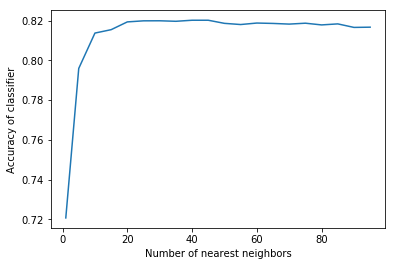

In [56]:
nn = [1] + [(x + 1) * 5 for x in range(19)]

scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in nn]

plot(nn, scores)
xlabel('Number of nearest neighbors')
ylabel('Accuracy of classifier')